### Notes
- ~~Convert tf to torch~~
- ~~Use Bahadir's code~~
	- ~~Includes custom training scheduler~~
	- ~~Custom optimizer~~

In [2]:
from torch.utils.data import DataLoader, Subset
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
import torchvision.transforms as transforms
import os
import pickle
from time import time
from tqdm.auto import tqdm
import torch
from resnet import ResNet34
import math

##### Load Data

In [3]:
NUM_MODELS = 1
EPOCHS = 35
NUM_TRAIN_SAMPLES = 50000
datasizes = np.linspace(50000, 40000, 21).astype(int)#np.logspace(math.log10(50000.1), math.log10(4900), 20, base=10).astype(int)
batch_schedule = np.linspace(200, 160, 21).astype(int)
datasizes, batch_schedule

(array([50000, 49500, 49000, 48500, 48000, 47500, 47000, 46500, 46000,
        45500, 45000, 44500, 44000, 43500, 43000, 42500, 42000, 41500,
        41000, 40500, 40000]),
 array([200, 198, 196, 194, 192, 190, 188, 186, 184, 182, 180, 178, 176,
        174, 172, 170, 168, 166, 164, 162, 160]))

In [4]:
device = 'cuda'

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
TEST_LOADER = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

trainset_nocrop_noflip = CIFAR10(root='./data', train=True, download=True, transform=transform_test)
trainloader_for_Jacobian  = DataLoader(trainset_nocrop_noflip, batch_size=1, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##### Define functions

In [5]:
# Model
def create_model():
	net = ResNet34()
	net = net.to(device)
	if device == 'cuda':
		net = torch.nn.DataParallel(net)
		cudnn.benchmark = True
	return net

In [6]:
def train_new(epochs: int, train_loader: DataLoader) -> torch.nn.DataParallel:
	# new model
	model = create_model()
      
	# setup optimizer + schedulers
	optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
	scheduler1  = CosineAnnealingLR(optimizer, T_max=20000)
	scheduler2 = LinearLR(optimizer, start_factor=0.0001, end_factor=1.0, total_iters=2500)
	scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2500])

	best = {'state_dict': model.state_dict(), 'acc': 0}
  
	# train model
	for _ in range(epochs):
		train(model, scheduler, optimizer, train_loader)
		acc = test(model)
		if acc > best['acc']:
			best = {'state_dict': model.state_dict(), 'acc': acc}
		#print(f'Epoch {epoch + 1} / {epochs} --\taccuracy: {acc:.5f}')
	
	print(f'returning new model - best test acc was: {best["acc"]}')
	model.load_state_dict(best['state_dict'])
	return model

def train(net: torch.nn.DataParallel, scheduler: SequentialLR, optimizer: torch.optim.SGD, train_loader: DataLoader) -> float:
	net.train()
	train_loss = 0
	correct = 0
	total = 0
	no_of_training_steps = 0
	for inputs, targets in train_loader:
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = net(inputs)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		_, predicted = outputs.max(1)
		total += targets.size(0)
		correct += predicted.eq(targets).sum().item()
		no_of_training_steps = no_of_training_steps + 1

		scheduler.step()

	return correct / total

def save_model(model: torch.nn.DataParallel, path: str):
	print('Saving..')
	parts = path.split('/')
	if len(parts) == 2 and not os.path.isdir(parts[0]):
		os.mkdir(parts[0])
	state = model.state_dict()
	torch.save(state, path)

def test(net: torch.nn.DataParallel) -> float:
	net.eval()
	test_loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for batch_idx, (inputs, targets) in enumerate(TEST_LOADER):
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = net(inputs)
			loss = criterion(outputs, targets)

			test_loss += loss.item()
			_, predicted = outputs.max(1)
			total += targets.size(0)
			correct += predicted.eq(targets).sum().item()

	return 100.*correct/total

	print('test',100.*correct/total, correct, total)
	if acc > best_acc:
		print('Saving..')
		state = {
			'net': net.state_dict(),
			'acc': acc
		}
		if not os.path.isdir('checkpoint'):
			os.mkdir('checkpoint')
		torch.save(state, './checkpoint/ckpt.pth')
		best_acc = acc

In [9]:
def plot_accuracies(accuracies: list[float], names: list[str]=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    x = np.linspace(100, 100 * datasizes[-1] / datasizes[0], datasizes.shape[0]).round().astype('int')
    y = np.mean(acclist, axis=1)
    plt.plot(x, y)

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xlabel('Percentage of Dataset Used in Training (%)')
  plt.ylabel(f'Average Model Test Accuracy (n={NUM_MODELS})')
  plt.grid()
  plt.gca().invert_xaxis()
  plt.show()

In [10]:
def save_to_file(path: str, obj):
	path_components = path.split('/')

	built_path = ''
	for component in path_components[:-1]:
		built_path += component + '/'
		if not os.path.exists(built_path):
			os.mkdir(built_path)

	with open(path, 'wb') as file:
		pickle.dump(obj, file)
		file.close()

In [19]:
# 30 epochs ~ 12.5 min 93.75% accuracy
model = train_new(30, DataLoader(trainset, batch_size=int(batch_schedule[0]), num_workers=2))

# model = create_model()

c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


returning new model - best test acc was: 86.35


In [12]:
# save_model(model, 'temp/model_weights')
# with open('./temp/model_weights', 'rb') as file:
# 	weights = torch.load(file)
# 	file.close()
# 	del file
# model.load_state_dict(weights)
# nt.load_weights('./temp/model_weights')

##### get jacobian norms of network per data point

In [20]:
# takes ~7 min
jacobian_norms = []
for inputs, labels in tqdm(trainloader_for_Jacobian):
  start = time()
  jacobian: torch.Tensor = torch.autograd.functional.jacobian(lambda x: criterion(model(x), labels.to(device)), inputs.to(device))
  jacobian_norms.append(np.linalg.norm(jacobian.to("cpu")))

jacobian_norms = np.array(jacobian_norms)

  0%|          | 0/50000 [00:03<?, ?it/s]

In [21]:
with open('./temp/jacobian_norms_2', 'rb') as file:
  jacobian_norms = pickle.load(file)
  file.close()
  del file
# with open('./temp/jacobian_norms_2', 'wb') as file:
#   pickle.dump(jacobian_norms, file)
#   file.close()
#   del file

##### reduce dataset by Jacobian norm

In [22]:
jac_val_acc: list[list[float]] = []
for data_size, batch_size in zip(datasizes, batch_schedule):
	keep_indices = np.argsort(jacobian_norms)[-data_size:]
	trainset_reduced = Subset(trainset, keep_indices)
	
	train_loader = DataLoader(trainset_reduced, batch_size=int(batch_size), shuffle=True, num_workers=2)
	print(f'Batch Size: {batch_size}, Dataset size: {data_size} ({100* data_size / datasizes[0]:.0f}% of dataset)')

	jac_val_acc.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/jacobian/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			jac_val_acc[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		jac_val_acc[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Batch Size: 200, Dataset size: 50000 (100% of dataset)
returning new model - best test acc was: 88.77
data size: 50000, model: 1 val acc = 88.77
Batch Size: 198, Dataset size: 49500 (99% of dataset)
returning new model - best test acc was: 89.02
data size: 49500, model: 1 val acc = 88.02
Batch Size: 196, Dataset size: 49000 (98% of dataset)
returning new model - best test acc was: 88.94
data size: 49000, model: 1 val acc = 87.32
Batch Size: 194, Dataset size: 48500 (97% of dataset)
returning new model - best test acc was: 89.36
data size: 48500, model: 1 val acc = 88.39
Batch Size: 192, Dataset size: 48000 (96% of dataset)
returning new model - best test acc was: 86.97
data size: 48000, model: 1 val acc = 86.97
Batch Size: 190, Dataset size: 47500 (95% of dataset)
returning new model - best test acc was: 89.38
data size: 47500, model: 1 val acc = 89.38
Batch Size: 188, Dataset size: 47000 (94% of dataset)
returning new model - best test acc was: 88.59
data size: 47000, model: 1 val acc

##### reduce dataset randomly

In [23]:
random_val_acc: list[list[float]] = []
for data_size, batch_size in zip(datasizes, batch_schedule):
	keep_indices = np.random.choice(NUM_TRAIN_SAMPLES, data_size, replace=False)
	trainset_reduced = Subset(trainset, keep_indices)
	train_loader = DataLoader(trainset_reduced, batch_size=int(batch_size), shuffle=True, num_workers=2)
	print(f'Dataset size: {data_size} ({100* data_size / datasizes[0]:.0f}% of dataset)')

	random_val_acc.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/rand/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			random_val_acc[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		random_val_acc[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Dataset size: 50000 (100% of dataset)
returning new model - best test acc was: 89.82
data size: 50000, model: 1 val acc = 89.82
Dataset size: 49500 (99% of dataset)
returning new model - best test acc was: 87.47
data size: 49500, model: 1 val acc = 87.47
Dataset size: 49000 (98% of dataset)
returning new model - best test acc was: 87.79
data size: 49000, model: 1 val acc = 86.59
Dataset size: 48500 (97% of dataset)
returning new model - best test acc was: 89.0
data size: 48500, model: 1 val acc = 88.31
Dataset size: 48000 (96% of dataset)
returning new model - best test acc was: 88.08
data size: 48000, model: 1 val acc = 87.46
Dataset size: 47500 (95% of dataset)
returning new model - best test acc was: 88.39
data size: 47500, model: 1 val acc = 87.72
Dataset size: 47000 (94% of dataset)
returning new model - best test acc was: 87.5
data size: 47000, model: 1 val acc = 86.69
Dataset size: 46500 (93% of dataset)
returning new model - best test acc was: 87.12
data size: 46500, model: 1 v

### Dataset is reduced by keeping HIGHEST n% of dataset based on given metric

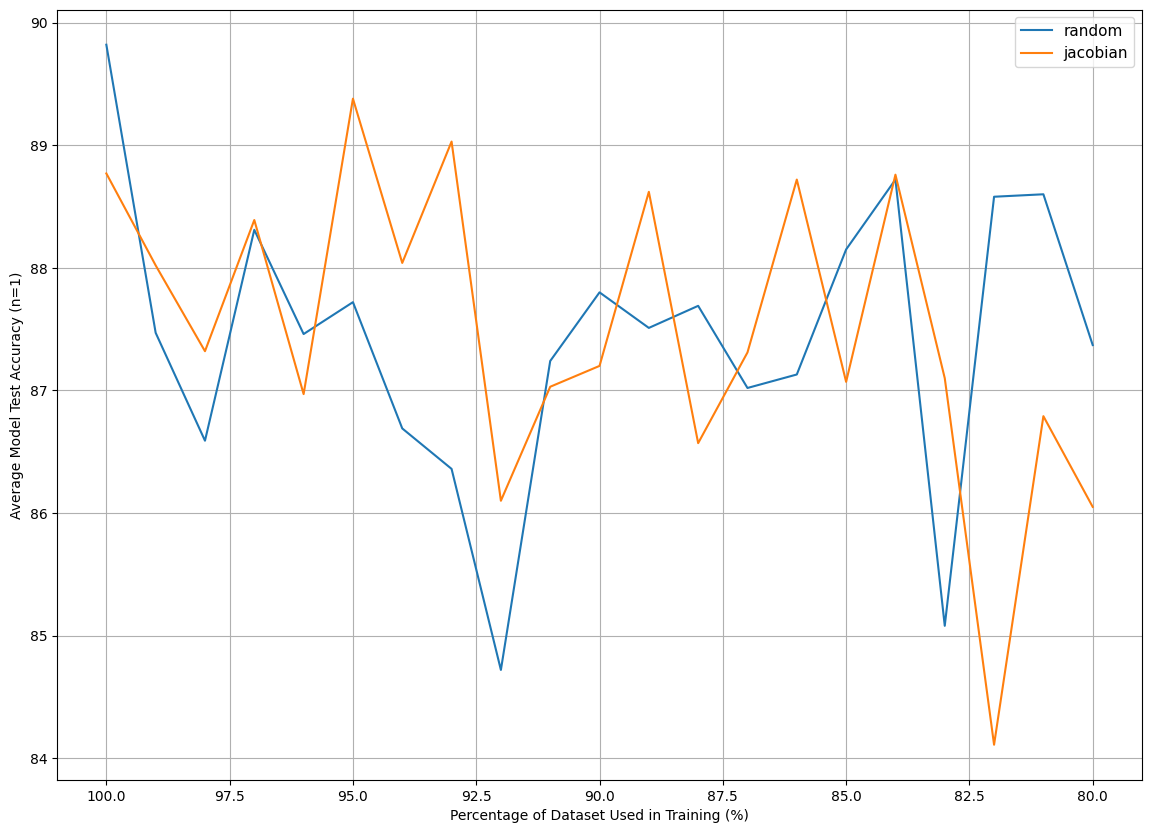

In [24]:
plot_accuracies([random_val_acc, jac_val_acc], names=['random', 'jacobian'])